# Building Sentiment Analysis models

Last updated : October 21th, 2022 

# Introduction

During this project, I will create an optimized Sentiment Analysis model based on a dataset created from Twitter reviews. This project will be completely created in Microsoft Azure Machine Learning Studio, and I will compare our model with the Microsoft Azure cognitive API service for Sentiment Analysis.

## 1. Data Preprocessing

We will first load and process our dataset.

### 1.1 Loading packages and the Dataset

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})
import dill

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

2022-10-19 17:20:42.666292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 17:20:45.424199: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 17:20:49.870165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-19 17:20:49.870326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset
import cred

subscription_id = cred.subscription_id
resource_group = cred.resource_group
workspace_name = cred.workspace_name

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='sentiment')
dataset.download(target_path='.', overwrite=False)

df = pd.read_csv('/mnt/batch/tasks/shared/LS_root/mounts/clusters/fatskill1/code/Users/fatskill/sentiment.csv', encoding='latin-1', header=None,
    names = ['label', 'id', 'date', 'query', 'user' , 'text'])

df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 1.2 Data Cleaning and EDA

Several columns seem unrelevant in this dataset. First of all, let's check unique values of the **QUERY** column.

In [3]:
df['query'].unique()

df.drop(columns="query", inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   user    1600000 non-null  object
 4   text    1600000 non-null  object
dtypes: int64(2), object(3)
memory usage: 61.0+ MB


,target,id,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


The QUERY column only contains "NO_QUERY", so we can just **delete it from our dataset.**

Now we can also **turn our date column into a datetime field.**

In [4]:
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

df.head()

/home/faskill/miniconda3/envs/pro7/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,target,id,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


The **user and date fields** are not relevant to our sentiment analysis so we can remove them from our database.

In [5]:

df = df[["label","text"]]

df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Now let's loot at the **repartition of labels** in our dataset :

[0 4]


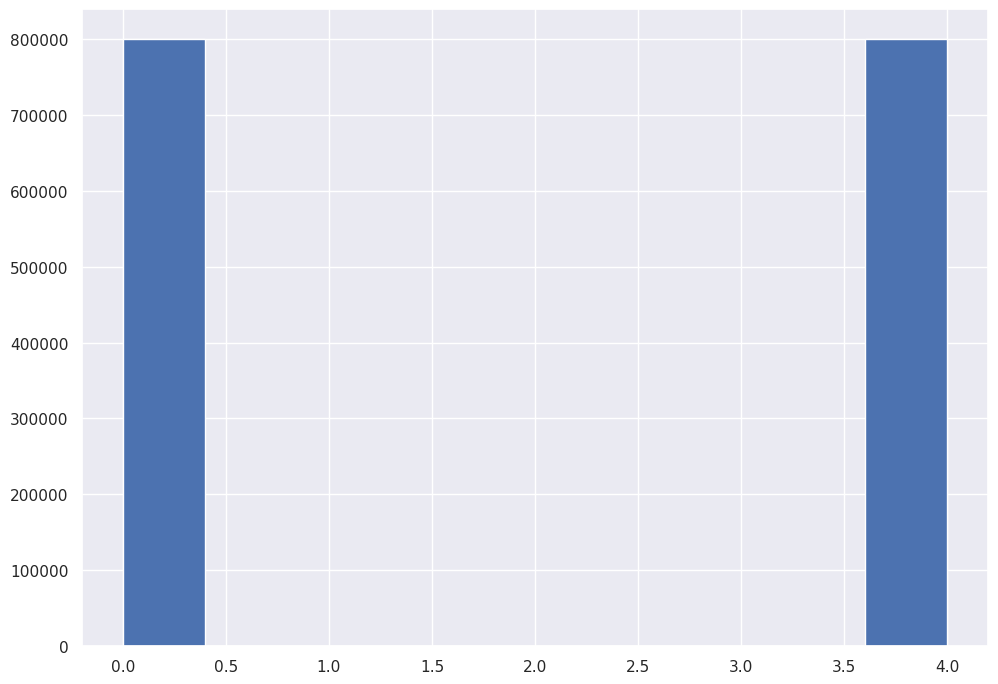

array([0, 1])

In [9]:
print(df.label.unique())
plt.hist(df.label)
plt.show()

#Since labels are only 0 or 4, we will convert them to 0 and 1
df.loc[df.label == 4, "label"] = 1

df.label.unique()

We can see that the **labels are perfectly balanced** with **800k samples** for both categories. We will not have to perform resampling of our dataset.

Now we will just quickly calculate the polarity of our text using the **VaderSentimentAnalysis** tool:

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_polarity(x):
    sentences = str(x).split('.')
    scores = []
    for s in sentences:
        scores.append(analyzer.polarity_scores(s)["compound"])
    return np.mean(scores) 

df["polarity"] = df["text"].apply(analyze_polarity)

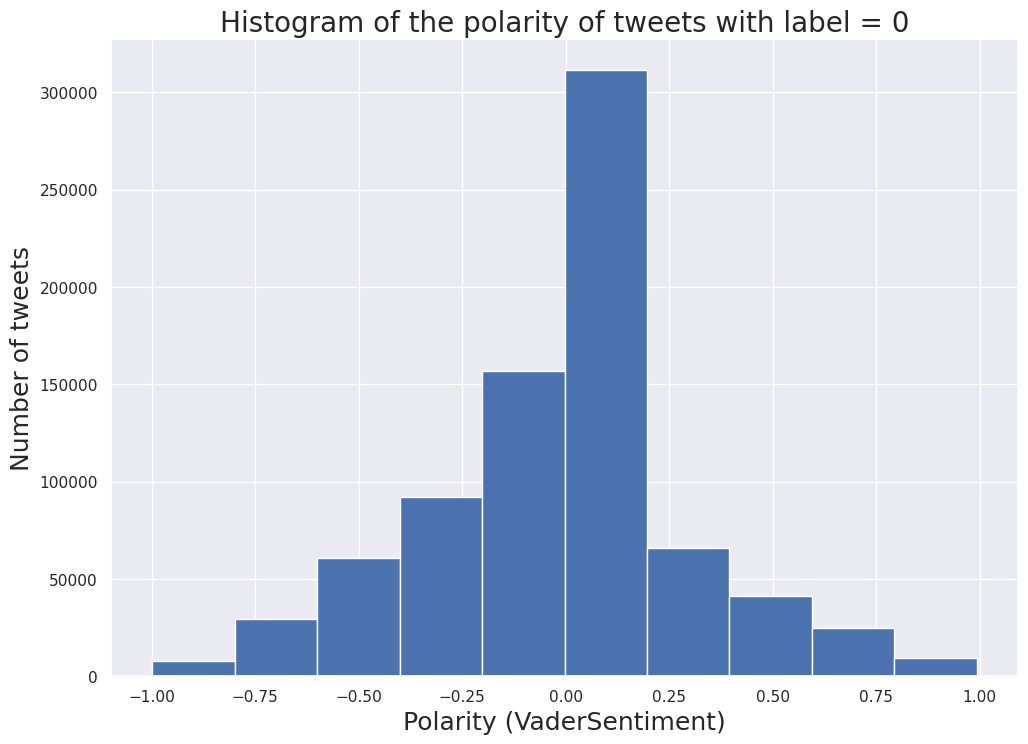

Average polarity (VaderSentiment) of tweets with label 0 : -0.032109591417991246


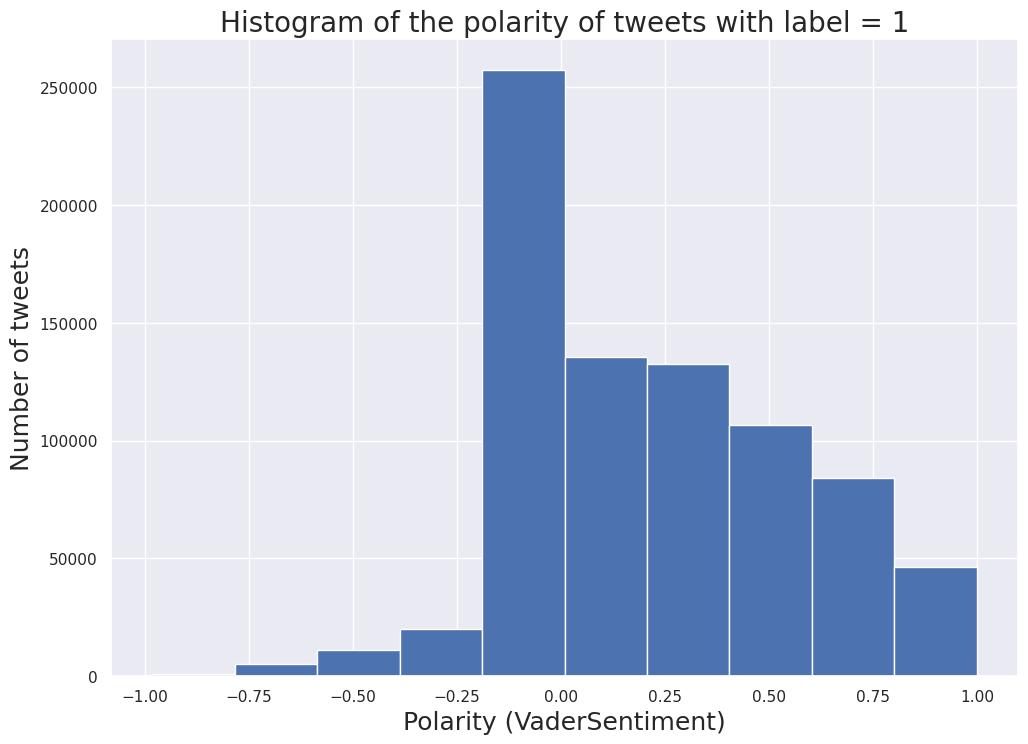

Average polarity (VaderSentiment) of tweets with label 1 : 0.23552064498962427


In [32]:
plt.hist(df[df.label==0]["polarity"])
plt.title("Histogram of the polarity of tweets with label = 0")
plt.xlabel("Polarity (VaderSentiment)")
plt.ylabel("Number of tweets")
plt.show()
print("Average polarity (VaderSentiment) of tweets with label 0 : {}".format(df[df.label==0]["polarity"].mean()))

plt.hist(df[df.label==1]["polarity"])
plt.title("Histogram of the polarity of tweets with label = 1")
plt.xlabel("Polarity (VaderSentiment)")
plt.ylabel("Number of tweets")
plt.show()
print("Average polarity (VaderSentiment) of tweets with label 1 : {}".format(df[df.label==1]["polarity"].mean()))

We can see that texts with a label of 0 have a **low polarity** while texts with a label of 1 have a rather **high polarity** which validates our dataset labels. 

Now we can start preprocessing our text data.

### 1.3 Text Data Preprocessing

In this part, we will use Spacy to **lemmatize our Twitter posts**.

Spacy will also **remove stopwords and punctuations** from our posts.

In [3]:
import spacy
import spacy_transformers
from tqdm.auto import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")

def lemmatize(x):
    doc = nlp(x)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return ' '.join(tokens)

df["lemma_text"] = df["text"].progress_apply(lemmatize)

df.head()

  0%|          | 0/1600000 [00:00<?, ?it/s]

,label,text,polarity,lemma_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.044875,@switchfoot http://twitpic.com/2y1zl Awww bumm...
1,0,is upset that he can't update his Facebook by ...,-0.206880,upset update Facebook texte cry result Schoo...
2,0,@Kenichan I dived many times for the ball. Man...,0.246950,@Kenichan dive time ball manage save 50 rest...
3,0,my whole body feels itchy and like its on fire,-0.250000,body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",-0.123475,@nationwideclass behave mad


In [5]:
with open("df.pkl", "wb") as file:
    dill.dump(df, file)

In [2]:
with open("df.pkl", "rb") as file:
    df = dill.load(file)
df.head()

,label,text,polarity,lemma_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.044875,@switchfoot http://twitpic.com/2y1zl Awww bumm...
1,0,is upset that he can't update his Facebook by ...,-0.206880,upset update Facebook texte cry result Schoo...
2,0,@Kenichan I dived many times for the ball. Man...,0.246950,@Kenichan dive time ball manage save 50 rest...
3,0,my whole body feels itchy and like its on fire,-0.250000,body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",-0.123475,@nationwideclass behave mad


### 1.4 Creating a Tensorflow dataframe

Now that we have preprocessed the text data, we will load it into a **Tensorflow dataframe**.

We will also perform a **test/train/validation split** to be able to evaluate our model without introducing data leakage. 

In [3]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1

train, test = train_test_split(df, test_size=TEST_SIZE)
train, val = train_test_split(train, test_size =TEST_SIZE/(1-TEST_SIZE))

X_train, X_test, X_val = train["lemma_text"], test["lemma_text"], val["lemma_text"]
y_train, y_test, y_val = train["label"], test["label"], val["label"]

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val))

next(iter(train_ds))

2022-10-19 17:21:03.297349: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 17:21:03.297418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fatskill1): /proc/driver/nvidia/version does not exist
2022-10-19 17:21:03.317631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<tf.Tensor: shape=(), dtype=string, numpy=b'dinner Palace fam   fb'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

We will also configure our dataframe for performance by **caching it, shuffling it and creating batches.**

This will significantly speed up the model training process.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 50

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
val_ds = configure_for_performance(val_ds)

### 1.5 Text Data Embedding

Our text data is not ready for analyzing, we need to turn our text data into vectors. 

In this part we will use the **TextVectorization kera layer** with a vocabulary size of 10k words.

Later on in this project, we will use the more performant **BERT embedding**.

In [5]:
#Basic text encoder using TextVectorization
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

Let's look at the most frequent words of our vocabulary :

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'go', 'good', 'day', 'work', 'get', 'like', 'love',
       'today', 'time', 'think', 'not', 'know', 'lol', 'want', 'miss',
       'thank', 'u', 'm'], dtype='<U27')

These words are not very interesting but we get expected results. 

Now we can look at the **encoding of a random Twitter post** :

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[1610,    6,  470, 4950,   78, 8008,  105,  381,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,  798,  175,  500,   31,  372, 1205,   42,   96,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 294,    1,   23,  365,  209,  564,  469, 9127,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])

As we can see, our documents have been turned into **multidimensional vectors**.

Now we can look into how our posts have been transformed within the encoder's vocabulary :

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'success get dress department eat brekkie early hungry'
Round-trip:  success get dress department eat brekkie early hungry            

Original:  b'@ishamay ohh post hmm   hope June 16   sad girl :|'
Round-trip:  [UNK] ohh post hmm hope june 16 sad girl           

Original:  b'Awww @chriscuzzy need vote fall blue line   http://bit.ly/pmvry'
Round-trip:  awww [UNK] need vote fall blue line httpbitlypmvry            



As we can see, even with the vocabulary size of 10k words, **some expressions have not been assigned to words** like random twitter handles.

Now that we finished encoding our text data, we are ready to start building a model.

## 2. Model Building

### 2.1 Simple Vectorization + RNN (LSTM)

We have chosen to use a Recurrent Neural Network (RNN) for this task after analyzing several Research Papers, and especially the [Comparative Study of CNN and RNN for Natural Language Processing, by Wenpeng Yin, Katharina Kann, Mo Yu and Hinrich Schütze](https://arxiv.org/abs/1702.01923v1)

The summary of their findings are presented below :

![RNN and CNN comparison](RNN_CNN_comparison.PNG)

As is obvious, for Sentiment Analysis (SentiC), **RNN are more performant than CNNs**.

We will first use a **Long Short-Term Memory (LSTM) layer** instead of a GRU layer for ease of use.

Let's define our model :

In [6]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trai

Now we can import a sample text data and verify that our untrained model will provide us with the same result with 2 different inputs :

In [12]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.00789264]


In [13]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 260ms/step
[-0.00789263]


We can now **compile our model** :

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

We use the **Adam optimizer and accuracy as our scoring metric** (this will automatically be transformed into Binary Accuracy by Keras since this is a Binary Classification probelm).

We implement **2 callbacks for our model** :

- A callback that will create a checkpoint if the validation accuracy exceeds the previous one
- A custom callback to clear the RAM which **prevents memory leakage during training**.

In [8]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

import gc
#Defining custom Call Back to prevent memory leak
class MemClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.enable()
        tf.keras.backend.clear_session() #Resets RAM usage after every EPOCH
        gc.collect()
        
mem_clear = MemClearCallback()


In [9]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    validation_steps=30,
                    callbacks=[mem_clear, model_checkpoint_callback])

Epoch 1/50
25600/25600 [==============================] - 390s 15ms/step - loss: 0.4855 - accuracy: 0.7492 - val_loss: 0.4779 - val_accuracy: 0.7533
Epoch 2/50
24082/25600 [===========================>..] - ETA: 22s - loss: 0.4646 - accuracy: 0.7645

The model is fitted on **50 epochs** (NB: Jupyter output has not been displayed since the browser reloaded during training).

In [10]:
model.evaluate(test_ds)

3200/3200 [==============================] - 14s 4ms/step - loss: 1.2470 - accuracy: 0.7252


[1.247040867805481, 0.7251999974250793]

After 50 epochs, we get an **accuracy of 0.725 on our validation set**.

Let's now plot our results :

(0.0, 1.3623144596815109)

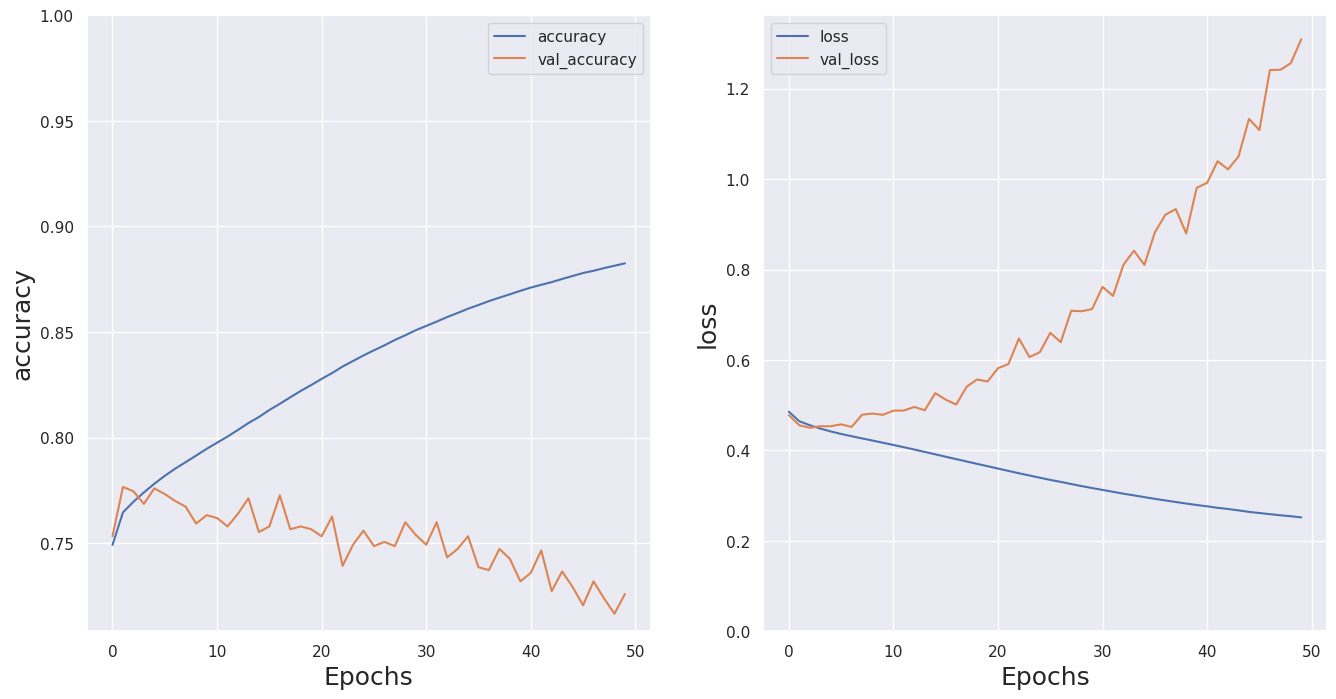

In [12]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

We can see that after about 10 epochs, our **model started overfitting** as is shown by the increase in (train) accuracy and the decrease in validation accuracy. 

The **best model** is the one trained on the 5th epoch. But let's try to **improve our model layers** before reaching conclusions.

We will now use 2 LSTM layers and a dropout layer to try to decrease overfitting and increase model performance.

### 2.2 Simple Vectorization + 2*LSTM 

Let's define our second version of the model :

In [7]:
#Adding Dropout layer to avoid overfitting and second LSTM layer

model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [8]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [9]:
checkpoint_filepath = "tmp_2/cp-{epoch:04d}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1)

import gc
#Defining custom Call Back to prevent memory leak
class MemClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.enable()
        tf.keras.backend.clear_session() #Resets RAM usage after every EPOCH
        gc.collect()
        
mem_clear = MemClearCallback()


history_2 = model_2.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    validation_steps=30,
                    callbacks=[mem_clear, model_checkpoint_callback])

Epoch 1/50
25599/25600 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.7475
Epoch 1: saving model to tmp_2/cp-0001.ckpt
25600/25600 [==============================] - 698s 27ms/step - loss: 0.4890 - accuracy: 0.7475 - val_loss: 0.4639 - val_accuracy: 0.7660
Epoch 2/50
25599/25600 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7625
Epoch 2: saving model to tmp_2/cp-0002.ckpt
25600/25600 [==============================] - 696s 27ms/step - loss: 0.4679 - accuracy: 0.7625 - val_loss: 0.4586 - val_accuracy: 0.7553
Epoch 3/50
25599/25600 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.7670
Epoch 3: saving model to tmp_2/cp-00

2022-10-19 17:34:55.456044: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-19 17:46:31.266491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-19 17:58:11.168476: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

We can see that the model is still overfitting since the validation accuracy goes down with the number of epochs.

Let's **evaluate our final model on our validation dataset** :

In [10]:
model_2.evaluate(val_ds) 

3200/3200 [==============================] - 37s 10ms/step - loss: 0.9928 - accuracy: 0.7386


[0.9927622079849243, 0.7386312484741211]

The accuracy has not been significantly improved and is at 0.73.

Let's plot our results :

(0.0, 0.9968383356928825)

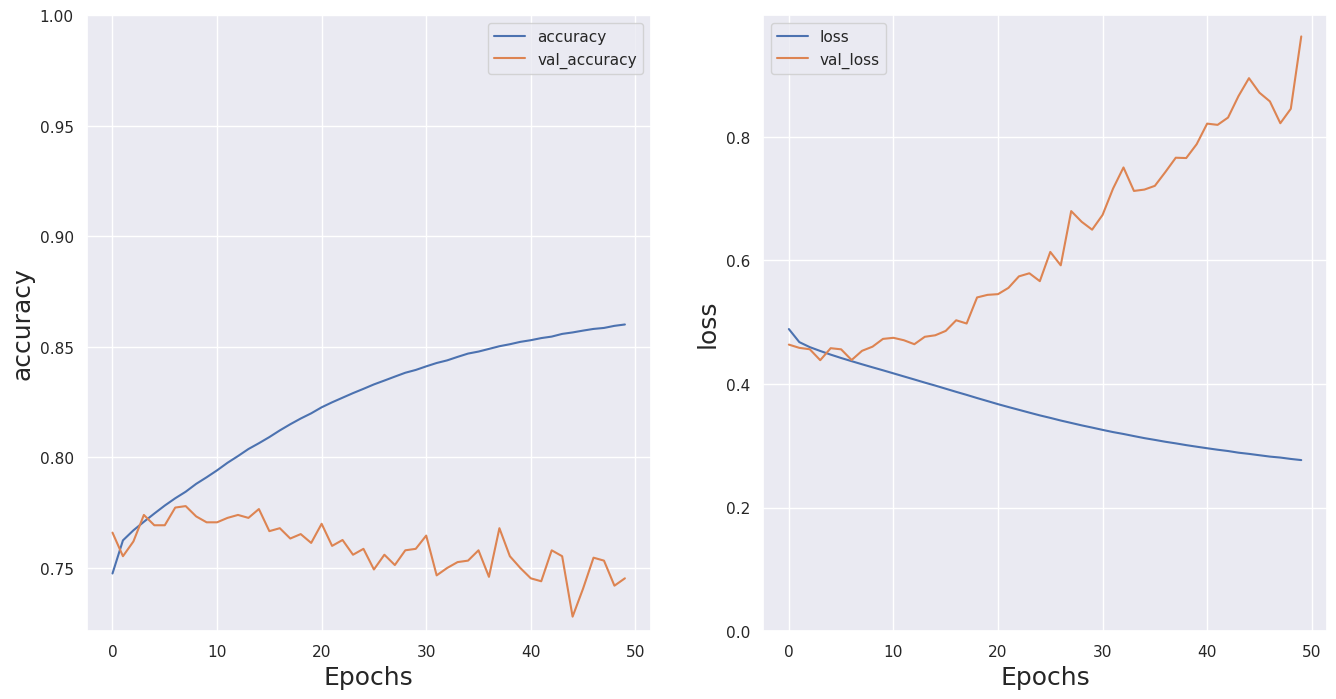

In [12]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_2, 'loss')
plt.ylim(0, None)

We can clearly see here that **our model is still overfitting after about 10 epochs**. We select the **checkpoint with the best performance at the 7th epoch** and rerun our evaluation :

In [22]:
os.listdir('tmp_2')

#checkpoint = tf.train.load_checkpoint("tmp_2/cp-0007.ckpt.index")

model_2.load_weights("tmp_2/cp-0007.ckpt")

model_2.evaluate(val_ds)


3200/3200 [==============================] - 24s 7ms/step - loss: 0.4667 - accuracy: 0.7709


[0.4667380750179291, 0.7709312438964844]

We have now **increased our accuracy on the validation dataset to 0.77**. 

Let's try to change our embedding to further improve those results.

We will use the BERT embedding for the rest of this project.

### 2.3 BERT Preprocessing

First we will load a fresh copy of our dataset :

In [2]:
with open("df.pkl", "rb") as file:
    df = dill.load(file)
df.head()

,label,text,polarity,lemma_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.044875,@switchfoot http://twitpic.com/2y1zl Awww bumm...
1,0,is upset that he can't update his Facebook by ...,-0.206880,upset update Facebook texte cry result Schoo...
2,0,@Kenichan I dived many times for the ball. Man...,0.246950,@Kenichan dive time ball manage save 50 rest...
3,0,my whole body feels itchy and like its on fire,-0.250000,body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",-0.123475,@nationwideclass behave mad


We will now load the BERT model from Tensorflow hub.

We select the **smallest model** since we are currently not able to use high performance computes due to limitations on my Azure account and we want to diminish training size as much as possible.

In [3]:
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub

#Using the most modern large BERT encoder since we have long strings
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessor")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 1024].

2022-10-16 09:21:45.838871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-16 09:21:45.998029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-16 09:21:45.998046: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-16 09:21:45.999029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Let's see how the BERT model vectorizes our text data :

In [4]:
embedding_model = tf.keras.Model(text_input, pooled_output)
print(embedding_model.summary())
sentences = tf.constant(["This is a test sentence to see how the model processes data"])
print(embedding_model(sentences))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

We can see that it **created a vector with 128 dimensions** (since we selected the SmallBERT L2-H128 model).

### 2.4 BERT + CNN

We will now begin by applying a simple CNN to our BERT encoded dataset.

Here is the schema of our model :

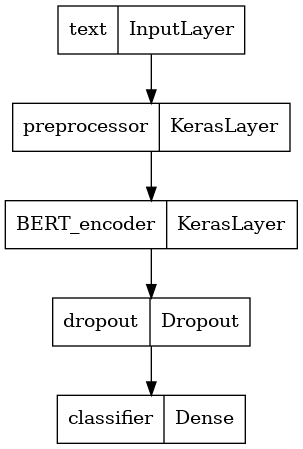

In [5]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

Just as before, we will now **tune our dataset and generate test, train and validation datasets:**

In [6]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train, test = train_test_split(df, test_size=TEST_SIZE)
train, val = train_test_split(train, test_size =TEST_SIZE/(1-TEST_SIZE))

#Using raw text (not lemmatized since it will be preprocessed with BERT preprocessor)
X_train, X_test, X_val = train["text"], test["text"], val["text"]
y_train, y_test, y_val = train["label"], test["label"], val["label"]

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val))

print(next(iter(train_ds)))

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
val_ds = configure_for_performance(val_ds)

(<tf.Tensor: shape=(), dtype=string, numpy=b'holy poopsauce atman! its been a long day. had fun at the abercrombies, missed the Carters though   hope i  feel better in the morning'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


We will use the **AdamW optimizer (improved version of Adam)** and the **Binary Accuracy metric**.

Let's now compile our model :

In [7]:
epochs = 10

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy()

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

We can now **start training** with similar callbacks as previous parts of the project:

In [8]:
import gc
epochs=10

checkpoint_filepath = 'tmp_bert/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1)

class MemClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.enable()
        tf.keras.backend.clear_session() #Resets RAM usage after every EPOCH
        gc.collect()
        
mem_clear = MemClearCallback()

history_bert = classifier_model.fit(x=train_ds,
                                    validation_data=val_ds,
                                    epochs=epochs,
                                    callbacks = [mem_clear, model_checkpoint_callback]
                                   )

Epoch 1/10
40000/40000 [==============================] - 6072s 152ms/step - loss: 0.5081 - binary_accuracy: 0.7380 - val_loss: 0.4133 - val_binary_accuracy: 0.8026
Epoch 2/10
40000/40000 [==============================] - 6045s 151ms/step - loss: 0.4138 - binary_accuracy: 0.8023 - val_loss: 0.3922 - val_binary_accuracy: 0.8180
Epoch 3/10
40000/40000 [==============================] - 6054s 151ms/step - loss: 0.3918 - binary_accuracy: 0.8148 - val_loss: 0.3836 - val_binary_accuracy: 0.8178
Epoch 4/10
40000/40000 [==============================] - 6074s 152ms/step - loss: 0.3784 - binary_accuracy: 0.8233 - val_loss: 0.3765 - val_binary_accuracy: 0.8279
Epoch 5/10
40000/40000 [==============================] - 6045s 151ms/step - loss: 0.3686 - binary_accuracy: 0.8287 - val_loss: 0.3754 - val_binary_accuracy: 0.8287
Epoch 6/10
40000/40000 [==============================] - 6054s 151ms/step - loss: 0.3606 - binary_accuracy: 0.8334 - val_loss: 0.3742 - val_binary_accuracy: 0.8325
Epoch 7/10

In [9]:
classifier_model.save('Data/bert_small_2_128_model')

In [38]:
classifier_model2 = tf.keras.models.load_model('Data/bert_small_2_128_model', compile=False)


In [40]:
epochs = 10

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy()

classifier_model2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

classifier_model2.evaluate(test_ds)

3200/3200 [==============================] - 314s 98ms/step - loss: 0.5979 - binary_accuracy: 0.7672


[0.5978504419326782, 0.7671812772750854]

We have reached an accuracy of **0.76 on the test dataset** which is **slightly inferior to our BERT + CNN Model**. 

Let's now apply the **same BERT embedding and use a Gated Recurrent Unit RNN** as mentionned in the cited Research paper.

### 2.5 BERT + RNN (GRU)

Just as before, we will download the smallest SmallBERT model (L-2 H-128) to **diminish training time**. 

In [23]:
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub

#Using the most modern large BERT encoder since we have long strings
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessor")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 1024].

embedding_model = tf.keras.Model(text_input, pooled_output)
print(embedding_model.summary())
sentences = tf.constant(["This is a test sentence to see how the model processes data"])
print(embedding_model(sentences))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

We can now build our model, we will **add a GRU layer between the encoder and the Dropout layer** :

In [29]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output']
    net = tf.keras.layers.GRU(200)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

We are now ready to compile the model with the same metrics and optimizer as before: **AdamW and Binary Accuracy**.

In [31]:
epochs=10

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.BinaryAccuracy()

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
classifier_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

Let's **train our model to compare the results** :

In [32]:
import gc

checkpoint_filepath = "tmp_bert_2/cp-{epoch:04d}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1)

class MemClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session() #Resets RAM usage after every EPOCH
        gc.collect()
        
mem_clear = MemClearCallback()

history_bert = classifier_model.fit(x=train_ds,
                                    validation_data=val_ds,
                                    epochs=epochs,
                                    callbacks = [mem_clear, model_checkpoint_callback]
                                   )

Epoch 1/10
25600/25600 [==============================] - ETA: 0s - loss: 0.5499 - binary_accuracy: 0.6962
Epoch 1: saving model to tmp_bert_2/cp-0001.ckpt
25600/25600 [==============================] - 10197s 398ms/step - loss: 0.5499 - binary_accuracy: 0.6962 - val_loss: 0.4778 - val_binary_accuracy: 0.7627
Epoch 2/10
 9835/25600 [==========>...................] - ETA: 1:42:13 - loss: 0.4844 - binary_accuracy: 0.7522

(0.0, 0.5561330690979958)

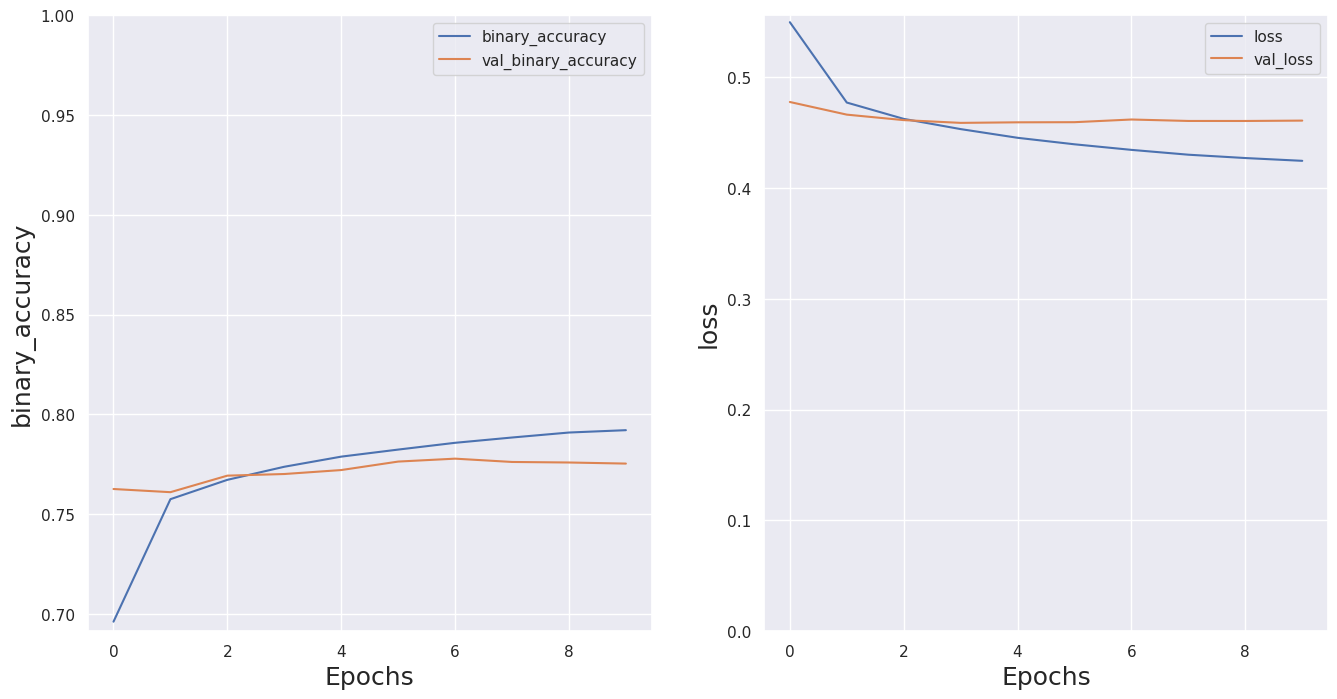

In [34]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_bert, 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_bert, 'loss')
plt.ylim(0, None)

In [35]:
classifier_model.evaluate(test_ds)

3200/3200 [==============================] - 394s 122ms/step - loss: 0.4612 - binary_accuracy: 0.7769


[0.46118980646133423, 0.7768999934196472]

In [36]:
classifier_model.save('Data/bert_rnn_gru')


We have reached a **0.776 accuracy which is slightly superior to the BERT + CNN model.**

This is our best result so we will **choose that model for the implementation of the Advanced Customizable Model**.

This accuracy could probably be significantly improved by **increasing the number of epochs**, which is not possible here due to limited computing power.